# Imports

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from torch import tensor, Tensor
import torchvision
from tqdm import tqdm
import os
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score


# Create Negative Images

100%|██████████| 9912422/9912422 [00:00<00:00, 44355610.42it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 126710976.80it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27032095.83it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20137979.67it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



<ipython-input-2-5947ab4c9905>:70: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  image_1 = torch.as_tensor(np.asarray(image_1))


<Figure size 640x480 with 0 Axes>

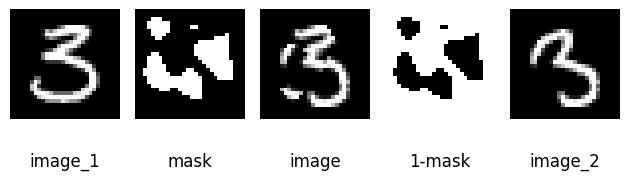

In [2]:
def prepare_data():
    # Define the transform function
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    train_mnist_dataset = torchvision.datasets.MNIST(root="./", train=True, transform=transform, download=True)
    n_train_samples = len(train_mnist_dataset)
    test_mnist_dataset = torchvision.datasets.MNIST(root="./", train=False, transform=transform, download=True)

    if not os.path.exists("transformed_dataset.pt"):
        random_pairs = np.random.randint(n_train_samples, size=[n_train_samples, 2])
        random_pairs = [(row[0], row[1]) for row in random_pairs]

        # Transform the data
        transformed_dataset = [
            create_negative_image(train_mnist_dataset[pair[0]][0].squeeze(), train_mnist_dataset[pair[1]][0].squeeze())
            for pair in tqdm(random_pairs)]

        # Save the transformed images to a folder
        torch.save(transformed_dataset, 'transformed_dataset.pt')


def create_mask(shape, iterations: int = 10):
    blur_filter_1 = np.array(((0, 0, 0), (0.25, 0.5, 0.25), (0, 0, 0)))
    blur_filter_2 = blur_filter_1.T

    # Create a random binary image
    image = np.random.randint(0, 2, size=shape)

    # Blur the image with the specified filter
    for i in range(iterations):
        image = np.abs(convolve2d(image, blur_filter_1, mode='same') / blur_filter_1.sum())
        image = np.abs(convolve2d(image, blur_filter_2, mode='same') / blur_filter_2.sum())

    # Binarize the blurred image, i.e. threshold it at 0.5
    mask = np.round(image).astype(np.uint8)

    return tensor(mask)


def create_negative_image(image_1: Tensor, image_2: Tensor):

    assert image_1.shape == image_2.shape, "Incompatible images and mask shapes."

    mask = create_mask((image_1.shape[0], image_1.shape[1]))

    image_1 = torch.mul(image_1, mask)
    image_2 = torch.mul(image_2, 1 - mask)

    return torch.add(image_1, image_2)


def create_negative_batch(images: Tensor):
    neg_imgs = []
    batch_size = images.shape[0]
    for _ in range(batch_size):
        idx1, idx2 = np.random.randint(batch_size, size=2)
        neg_imgs.append(create_negative_image(images[idx1].squeeze(), images[idx2].squeeze()))
    return torch.unsqueeze(torch.stack(neg_imgs), dim=1)


# Load the MNIST dataset
mnist = torchvision.datasets.MNIST(root='data/', download=True)

# Get the first instance of the digit 1
image_1, _ = mnist[np.random.randint(len(mnist))]
image_2, _ = mnist[np.random.randint(len(mnist))]

image_1 = torch.as_tensor(np.asarray(image_1))
image_2 = torch.as_tensor(np.asarray(image_2))

mask = create_mask((28, 28))
image = create_negative_image(image_1, image_2)

plt.figure()

# Create the subplot
fig, ax = plt.subplots(1, 5)
images = [image_1, mask, image, 1 - mask, image_2]
names = ["image_1", "mask", "image", "1-mask", "image_2"]
# Add the images to the subplot
for i, image in enumerate(images):
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(names[i], y=-0.5)

# Show the subplot
plt.tight_layout()
plt.show()

# Required classes and Functions

In [3]:
def goodness_score(pos_acts, neg_acts, threshold=2):


    pos_goodness = -torch.sum(torch.pow(pos_acts, 2)) + threshold
    neg_goodness = torch.sum(torch.pow(neg_acts, 2)) - threshold
    pos_goodness = pos_goodness.unsqueeze(0)
    neg_goodness = neg_goodness.unsqueeze(0)
    loss = torch.log(1+ torch.exp(
                    torch.cat([pos_goodness, neg_goodness ])
                    )).mean()
    return loss


def get_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    return dict(accuracy_score=acc)


class FF_Layer(nn.Linear):
    def __init__(self, in_features: int, out_features: int, n_epochs: int, bias: bool, device):
        super().__init__(in_features, out_features, bias=bias)
        self.n_epochs = n_epochs
        self.opt = torch.optim.Adam(self.parameters())
        self.goodness = goodness_score
        self.to(device)
        self.ln_layer = nn.LayerNorm(normalized_shape=[1, out_features]).to(device)

    def ff_train(self, pos_acts, neg_acts):

        self.opt.zero_grad()
        goodness = self.goodness(pos_acts, neg_acts)
        goodness.backward()
        self.opt.step()

    def forward(self, input):
        input = super().forward(input)
        input = self.ln_layer(input.detach())
        return input


class Unsupervised_FF(nn.Module):
    def __init__(self, n_layers: int = 4, n_neurons=2000, input_size: int = 28 * 28, n_epochs: int = 100,
                 bias: bool = True, n_classes: int = 10, n_hid_to_log: int = 3, device=torch.device("cuda:0")):
        super().__init__()
        self.n_hid_to_log = n_hid_to_log
        self.n_epochs = n_epochs
        self.device = device

        ff_layers = [
            FF_Layer(in_features=input_size if idx == 0 else n_neurons,
                     out_features=n_neurons,
                     n_epochs=n_epochs,
                     bias=bias,
                     device=device) for idx in range(n_layers)]

        self.ff_layers = ff_layers
        self.last_layer = nn.Linear(in_features=n_neurons * n_hid_to_log, out_features=n_classes, bias=bias)
        self.to(device)
        self.opt = torch.optim.Adam(self.last_layer.parameters())
        self.loss = torch.nn.CrossEntropyLoss(reduction="mean")

    def train_ff_layers(self, pos_dataloader, neg_dataloader):
        outer_tqdm = tqdm(range(self.n_epochs), desc="Training FF Layers", position=0)
        for epoch in outer_tqdm:
            inner_tqdm = tqdm(zip(pos_dataloader, neg_dataloader), desc=f"Training FF Layers | Epoch {epoch}",
                              leave=False, position=1)
            for pos_data, neg_imgs in inner_tqdm:
                pos_imgs, _ = pos_data
                pos_acts = torch.reshape(pos_imgs, (pos_imgs.shape[0], 1, -1)).to(self.device)
                neg_acts = torch.reshape(neg_imgs, (neg_imgs.shape[0], 1, -1)).to(self.device)

                for idx, layer in enumerate(self.ff_layers):
                    pos_acts = layer(pos_acts)
                    neg_acts = layer(neg_acts)
                    layer.ff_train(pos_acts, neg_acts)

    def train_last_layer(self, dataloader: DataLoader):
        num_examples = len(dataloader)
        outer_tqdm = tqdm(range(self.n_epochs), desc="Training Last Layer", position=0)
        loss_list = []
        for epoch in outer_tqdm:
            epoch_loss = 0
            inner_tqdm = tqdm(dataloader, desc=f"Training Last Layer | Epoch {epoch}", leave=False, position=1)
            for images, labels in inner_tqdm:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.opt.zero_grad()
                preds = self(images)
                loss = self.loss(preds, labels)
                epoch_loss += loss
                loss.backward()
                self.opt.step()
            loss_list.append(epoch_loss / num_examples)
            # Update progress bar with current loss
        return [l.detach().cpu().numpy() for l in loss_list]

    def forward(self, image: torch.Tensor):
        image = image.to(self.device)
        image = torch.reshape(image, (image.shape[0], 1, -1))
        concat_output = []
        for idx, layer in enumerate(self.ff_layers):
            image = layer(image)
            if idx > len(self.ff_layers) - self.n_hid_to_log - 1:
                concat_output.append(image)
        concat_output = torch.concat(concat_output, 2)
        logits = self.last_layer(concat_output)
        return logits.squeeze()

    def evaluate(self, dataloader: DataLoader, dataset_type: str = "train"):
        self.eval()
        inner_tqdm = tqdm(dataloader, desc=f"Evaluating model", leave=False, position=1)
        all_labels = []
        all_preds = []
        for images, labels in inner_tqdm:
            images = images.to(self.device)
            labels = labels.to(self.device)
            preds = self(images)
            preds = torch.argmax(preds, 1)
            all_labels.append(labels.detach().cpu())
            all_preds.append(preds.detach().cpu())
        all_labels = torch.concat(all_labels, 0).numpy()
        all_preds = torch.concat(all_preds, 0).numpy()
        metrics_dict = get_metrics(all_preds, all_labels)
        print(f"{dataset_type} dataset scores: ", "\n".join([f"{key}: {value}" for key, value in metrics_dict.items()]))


def train(model: Unsupervised_FF, pos_dataloader: DataLoader, neg_dataloader: DataLoader):
    model.train()
    model.train_ff_layers(pos_dataloader, neg_dataloader)
    return model.train_last_layer(pos_dataloader)


def plot_loss(loss):
    # plot the loss over epochs
    fig = plt.figure()
    plt.plot(list(range(len(loss))), loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Plot")
    plt.savefig("Loss Plot.png")
    plt.show()

# Training the Model and Showing the results

100%|██████████| 9912422/9912422 [00:00<00:00, 161644257.48it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40311378.98it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 58429504.12it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22151777.64it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 60000/60000 [01:48<00:00, 553.59it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training FF Layers:   0%|          | 0/2 [00:00<?, ?it/s]
Training FF Layers | Epoch 0: 0it [00:00, ?it/s]
Training FF Layers | Epoch 0: 1it [00:03,  3.41s/it]
Training FF Layers | Epoch 0: 7it [00:03,  2.69it/s]
Training FF Layers | Epoch 0: 14it [00:03,  6.30it/s]
Training FF Layers | Epoch 0: 21it [00:03, 10.82it/s]
Training FF Layers | Epoch 0: 28it [00:03, 16.24it/s]
Training FF Layers | Epoch 0: 35it [00:03, 22.22it/s]
Training FF Layers | Epoch 0: 43it [00:0

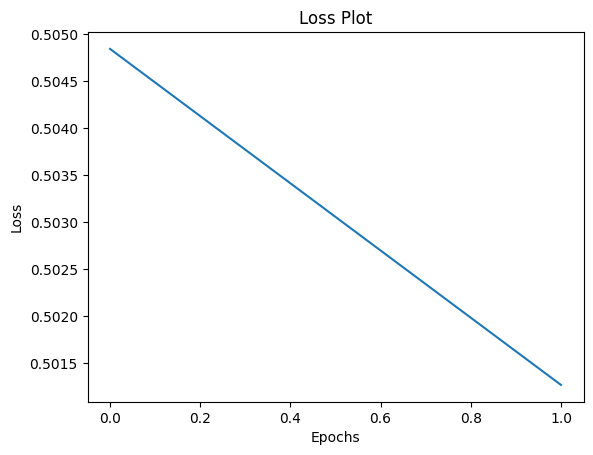


Evaluating model:  99%|█████████▊| 924/938 [00:09<00:00, 107.07it/s]
                                                                    

Train dataset scores:  accuracy_score: 0.8990333333333334



Evaluating model:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

Evaluating model:  94%|█████████▍| 148/157 [00:02<00:00, 70.16it/s]
                                                                   

Test dataset scores:  accuracy_score: 0.8949


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
prepare_data()


transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
pos_dataset = torchvision.datasets.MNIST(root='./', download=False, transform=transform, train=True)
pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=4)
neg_dataset = torch.load('transformed_dataset.pt')
neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=4)


test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)


unsupervised_ff = Unsupervised_FF(device=device, n_epochs=2)

loss = train(unsupervised_ff, pos_dataloader, neg_dataloader)

plot_loss(loss)

unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")